# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

If you do not have a GPU, uncomment and run the next commands.


In [75]:
import sys
sys.version

'3.9.16 (main, Mar  8 2023, 14:00:05) \n[GCC 11.2.0]'

In [76]:
! python --version

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Python 3.9.16


In [77]:
! which python

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/home/ramez/miniconda3/envs/thesis/bin/python


In [78]:
import tensorflow as tf

#### GPU Check

In [79]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/usr/bin/zsh: /home/ramez/miniconda3/envs/thesis/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [80]:
from tensorflow import keras

In [81]:
import numpy as np

In [82]:
from sklearn.metrics import cohen_kappa_score

In [83]:
## Local EfficientNetLite (Customized by the Competition)
from efficientnet_lite import EfficientNetLiteB0

In [84]:
from sklearn.model_selection import KFold

In [85]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [86]:
from tensorflow.keras.callbacks import TensorBoard

In [87]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [88]:
import matplotlib.pyplot as plt

In [89]:
from itertools import accumulate

In [90]:
import os

In [91]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# 2. Utility Functions

You can use this function to load your training data.

In [92]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=config.input_shape[:2], shuffle=False, 
                                                               batch_size=100000, label_mode='int')

    # get the class names (folder names) from the dataset object
    global class_names
    class_names = tf_eval_data.class_names
    
    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

# 4. Loading data

In [111]:
# dataset_path_train="/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/images_copy_processed/"
dataset_path_train_val = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_train/"

In [112]:
dataset_path_test = "/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/Data/ops_sat_test/"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

### Model Configuration

In [113]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="OPS-SAT-Thesis-Project",

    # track hyperparameters and run metadata with wandb.config
    config={
        "dropout": 0.5,
        "num_classes": 8,
        "input_shape": (200, 200, 3),
        "model_weights": "imagenet",
        "output_layer_activation": "softmax",
        "model_optimizer": "adam",
        "loss_fun": "sparse_categorical_crossentropy",
        "model_metrics": ["SparseCategoricalAccuracy"],
        "early_stopping_monitor": "val_sparse_categorical_accuracy",
        "early_stopping_patience": 3,
        "model_checkpoint_monitor": "val_sparse_categorical_accuracy",
        "cross_validation_k": 5,
        "model_epochs": 100,
        "model_batch_size": 8
    }
)

config = wandb.config

In [147]:
#Loading dataset
x_train_val, y_train_val = get_images_from_path(dataset_path_train_val)

Found 227 files belonging to 8 classes.


In [148]:
## class_names_labels dict
class_name_label = {}
for i, class_name in enumerate(class_names):
    class_name_label[i] = class_name

In [149]:
#Loading dataset
x_test, y_test = get_images_from_path(dataset_path_test)

Found 40 files belonging to 8 classes.


In [150]:
## class_names_labels dict
class_name_label_test = {}
for i, class_name in enumerate(class_names):
    class_name_label_test[i] = class_name

In [151]:
## Check if classes are identical with labels in both splits
if class_name_label == class_name_label_test:
    print("Ok")
else:
    print("Error - Class Mapping Are Mismatched")

Ok


# 5. Model training

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

### Load The Model With ImageNet Weights

### Compile The model

### Early Stopping and Best Model Callbacks 

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [119]:
def model_init():
    global model
    global early_stopping
    global checkpoint
    
    model = EfficientNetLiteB0(classes=config.num_classes, weights=config.model_weights, input_shape=config.input_shape, classifier_activation=None, include_top = False)
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(config.dropout)(x)
    output_layer = Dense(config.num_classes, activation=config.output_layer_activation)(x)
    model = Model(inputs=model.input, outputs=output_layer)
    # model.summary()
    
    model.compile(optimizer=config.model_optimizer,
                  # loss="sparse_categorical_crossentropy",
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  loss=config.loss_fun,
                  # metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 metrics=config.model_metrics)
    
    early_stopping = EarlyStopping(monitor=config.early_stopping_monitor, patience=config.early_stopping_patience)
    checkpoint = ModelCheckpoint('best_weights.h5', monitor=config.model_checkpoint_monitor, save_best_only=True)
    
# wandb_callback=wandb.keras.WandbCallback()

### Without K fold Cross Validation but with TensorBoard (With Early Stopping)

In [120]:
# tensorboard_callback = TensorBoard(log_dir='./logs')

In [121]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x_train_val, y_train_val, validation_data=(x_test, y_test), epochs= 100, verbose=1, batch_size=8, 
#                         callbacks=[early_stopping, tensorboard_callback])

In [122]:
# !tensorboard --logdir=./logs

### With K fold Cross Validation but without TensorBoard (With Early Stopping)

In [123]:
kf = KFold(n_splits=config.cross_validation_k, shuffle=True)

In [124]:
# Train and evaluate the model using K-fold cross-validation
scores = []
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

## Initializing the model
model_init()

## counter for folds
i = 1

for train_idx, val_idx in kf.split(x_train_val):
    X_train = tf.gather(x_train_val, train_idx)
    y_train = tf.gather(y_train_val, train_idx)
    X_val = tf.gather(x_train_val, val_idx)
    y_val = tf.gather(y_train_val, val_idx)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= config.model_epochs, verbose=1, batch_size=config.model_batch_size, 
                        callbacks=[early_stopping, checkpoint])

    training_accuracy.append(history.history['sparse_categorical_accuracy'])
    validation_accuracy.append(history.history['val_sparse_categorical_accuracy'])
    training_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])
    
    model.load_weights('best_weights.h5')
    score = model.evaluate(X_val, y_val)
    scores.append(score[1])
    
    wandb.log({"Best Validation Loss for Folds": score[0]})
    wandb.log({"Best Validation Accuracy for Folds" : score[1]})
    
    # Define the current and new file names
    current_name = 'best_weights.h5'
    new_name = 'fold_' + str(i) + '_best_model_weights.h5'
    
    i+=1

    # Rename the file
    os.rename(current_name, new_name)
    
    ## Reseting the model for the next fold
    model_init()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.6537 - sparse_categorical_accuracy: 0.3812

/home/ramez/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


23/23 [==============================] - 7s 158ms/step - loss: 1.6537 - sparse_categorical_accuracy: 0.3812 - val_loss: 2.8119 - val_sparse_categorical_accuracy: 0.1522
Epoch 2/100
23/23 [==============================] - 3s 141ms/step - loss: 0.8528 - sparse_categorical_accuracy: 0.7182 - val_loss: 2.6540 - val_sparse_categorical_accuracy: 0.2826
Epoch 3/100
23/23 [==============================] - 3s 135ms/step - loss: 0.7898 - sparse_categorical_accuracy: 0.7238 - val_loss: 2.6308 - val_sparse_categorical_accuracy: 0.3261
Epoch 4/100
23/23 [==============================] - 3s 135ms/step - loss: 0.6906 - sparse_categorical_accuracy: 0.7901 - val_loss: 2.2010 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 137ms/step - loss: 0.5145 - sparse_categorical_accuracy: 0.8343 - val_loss: 1.2685 - val_sparse_categorical_accuracy: 0.6304
Epoch 6/100
23/23 [==============================] - 3s 117ms/step - loss: 0.5598 - sparse_categorical_accu

In [125]:
# Print the mean validation accuracy
print('Validation accuracy mean: {:.2f} (std {:.2f})'.format(np.mean(scores), np.std(scores)))

Validation accuracy mean: 0.64 (std 0.11)


In [126]:
scores

[0.782608687877655,
 0.695652186870575,
 0.6000000238418579,
 0.6888889074325562,
 0.4444444477558136]

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [127]:
## select the model with the best fold's validation accuracy
maximum = max(scores)
index_of_maximum = scores.index(maximum)
best_fold = index_of_maximum + 1

model.load_weights('fold_' + str(best_fold) + '_best_model_weights.h5')

In [128]:
predictions = np.zeros(len(y_test), dtype=np.int8)
# inference loop
for e, (image, target) in enumerate(zip(x_test, y_test)):
    image = np.expand_dims(np.array(image), axis=0)
    output = model.predict(image)
    predictions[e] = np.squeeze(output).argmax()
#Keras model score
score_keras = 1 - cohen_kappa_score(y_test.numpy(), predictions)
print("Score:",score_keras)

Score: 0.4


### Accuracy 

In [130]:
# assuming you have two lists, predicted and actual
correct = 0
total = len(y_test.numpy())

for pred, label in zip(predictions, y_test.numpy()):
    if pred == label:
        correct += 1

accuracy = correct / total

print("Accuracy: ", accuracy)

Accuracy:  0.65


## Train - Validation Visualization

In [131]:
eps_per_fold = [len(sub_list) for sub_list in training_accuracy]
eps_per_fold

[13, 13, 7, 11, 6]

In [132]:
eps_per_fold_cum = list(accumulate(eps_per_fold))

In [133]:
training_accuracy = [element for sublist in training_accuracy for element in sublist]
validation_accuracy = [element for sublist in validation_accuracy for element in sublist]
training_loss = [element for sublist in training_loss for element in sublist]
validation_loss = [element for sublist in validation_loss for element in sublist]

In [134]:
eps_per_fold_cum

[13, 26, 33, 44, 50]

In [135]:
xs = []
ys = []
for i in range(config.cross_validation_k):
    xs.append(eps_per_fold_cum[i]+1)
    ys.append(training_accuracy[eps_per_fold_cum[0]-1])
# xs = [eps_per_fold_cum[0]+1, eps_per_fold_cum[1]+1, eps_per_fold_cum[2]+1, eps_per_fold_cum[3]+1, eps_per_fold_cum[4]+1]
# ys = [training_accuracy[eps_per_fold_cum[0]-1], training_accuracy[eps_per_fold_cum[1]-1], training_accuracy[eps_per_fold_cum[2]-1],
#          training_accuracy[eps_per_fold_cum[3]-1], training_accuracy[eps_per_fold_cum[4]-1]]

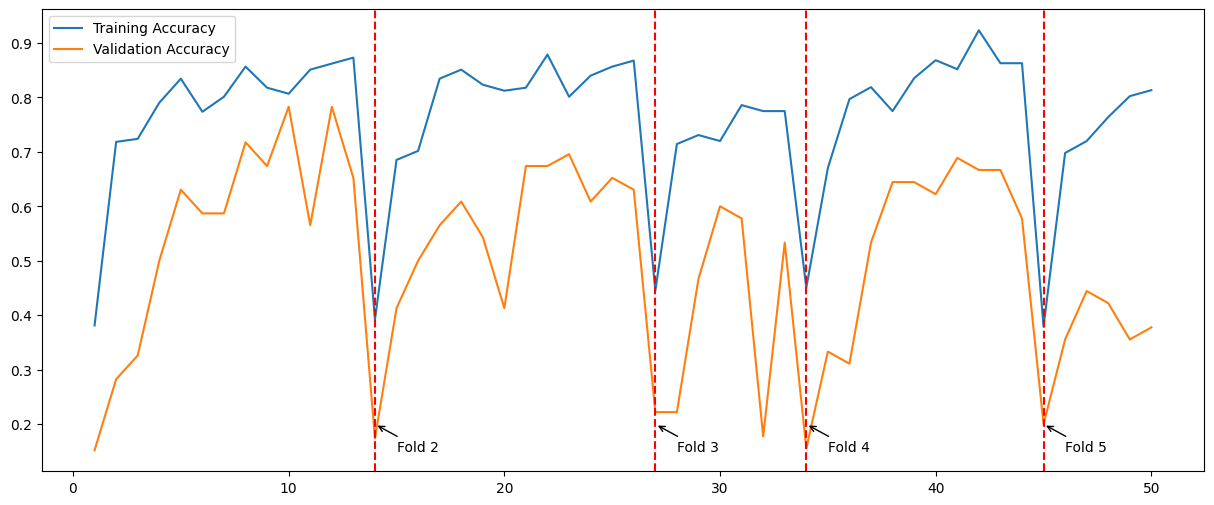

In [136]:
x1 = list(range(1, len(training_accuracy) + 1))
x2 = list(range(1, len(validation_accuracy) + 1))

fig = plt.figure(figsize=(15, 6))

# Create the plot
plt.plot(x1, training_accuracy, label='Training Accuracy')
plt.plot(x2, validation_accuracy, label='Validation Accuracy')



# Add points with labels
for i in range(config.cross_validation_k-1):
    plt.axvline(x=xs[i], color='red', linestyle='--')
# plt.axvline(x=xs[0], color='red', linestyle='--')
# plt.axvline(x=xs[1], color='red', linestyle='--')
# plt.axvline(x=xs[2], color='red', linestyle='--')
# plt.axvline(x=xs[3], color='red', linestyle='--')

# Add annotations to the lines
for i in range(config.cross_validation_k-1):
    plt.annotate('Fold '+str(i+2), xy=(xs[i], 0.2), xytext=(xs[i]+1, 0.15),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# plt.annotate('Fold 2', xy=(xs[0], 0.5), xytext=(xs[0]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 3', xy=(xs[1], 0.5), xytext=(xs[1]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 4', xy=(xs[2], 0.5), xytext=(xs[2]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('Fold 5', xy=(xs[3], 0.5), xytext=(xs[3]+1, 0.4),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.axvline(x=xs[4], color='red', linestyle='--')
# plt.scatter(xs, ys, color='red')
# plt.annotate('Point 1', (2, 4), textcoords="offset points", xytext=(0,10), ha='center')
# plt.annotate('Point 2', (4, 8), textcoords="offset points", xytext=(0,10), ha='center')


# Add a legend
plt.legend()

# Enable the grid
# plt.grid(True)

# Show the plot
plt.show()

## Log Unified Test Set and its predictions

In [156]:
prediction_names = [class_name_label[num] for num in predictions]
actual_names = [class_name_label[num] for num in y_test.numpy()]

In [164]:
# assuming you have lists of images, predictions, and actual labels
for i, (img, pred, label) in enumerate(zip(x_test, prediction_names, actual_names)):
    wandb.log({'All Predictions - Unified Test Set': wandb.Image(img, caption='predicted: {}, actual: {}'.format(pred, label))})

In [163]:
pred_is_actual = [x == y for x, y in zip(prediction_names, actual_names)]

In [165]:
wandb.finish()

Best Validation Accuracy for Folds,█▆▄▆▁
Best Validation Loss for Folds,▁▄▆▃█
Best Validation Accuracy for Folds,0.44444
Best Validation Loss for Folds,2.20347


In [ ]:
## Load the Model without any weight initialization
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# model.summary()

In [ ]:
## Saving model
# model.save_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/submit_19.h5')

In [ ]:
# model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
# # model = EfficientNetLiteB0(include_top=False, classes=num_classes, weights='imagenet', input_shape=input_shape, classifier_activation=None)
# model.load_weights('/home/ramez/Politechnika_Slaska_MSc/Thesis/Competition/submission/model_patterns_20epochs.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [ ]:
# #Model shall be compiled before testing.
# model.compile()

# #Creating empty predictions
# predictions = np.zeros(len(y_test), dtype=np.int8)
# # inference loop
# for e, (image, target) in enumerate(zip(x_test, y_test)):
#     image = np.expand_dims(np.array(image), axis=0)
#     output = model.predict(image)
#     predictions[e] = np.squeeze(output).argmax()
# #Keras model score
# score_keras = 1 - cohen_kappa_score(y_test.numpy(), predictions)
# print("Score:",score_keras)